# Read me
This template is meant to be a starter for your customized DREEM output data analysis.

- To install this library, please check the installation on the [Git repo](https://github.com/yvesmartindestaillades/NAP).
- To learn how to use this library, please get through the [tutorial](tutorial.ipynb).


# Turner overthrown

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import exists, dirname
import os, sys
import numpy as np
import seaborn as sns
import json
from dreem_nap import data_wrangler, data_manip, database, plot, utils
from dreem_nap.study import Study


# Step 1: Data wrangling
### Step 1.1: Define your study and some basics about your project

In [2]:
# Set your root folder for the database (at the moment, keep Yves)
folder = 'Yves'

path_to_data = 'data'

# Firebase credentials file
firebase_credentials_file = f"{path_to_data}/credentials_firebase.json"
with open(firebase_credentials_file) as file:
    firebase_credentials = json.load(file)

# Select your study
study_name = 'all samples' 

## Set your base coverage high-pass filter value
min_bases_cov = 1000 

# Set the resolution for the plots
mpl.rcParams['figure.dpi'] = 600 # the highest the resolution, the slowest the plotting
mpl.rcParams["figure.figsize"] = [25,7]
#plt.rcParams["figure.autolayout"] = True

# Depending on the study you select, you'll get a series of samples. You can also create new studies using this dictionary.
# Here's an example.
studies = data_wrangler.load_studies( f"{path_to_data}/samples.csv")

study = studies.loc[study_name]
study

name                                                 all samples
description                      Simply all of the valid samples
samples        [A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, B1, ...
title                                                        NaN
conditions     [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
Name: all samples, dtype: object

### Step 1.2: Process new pickle files and push them to Firebase
- Select which samples you want to push to Firebase.
To plot automatically arrays of samples, see [tutorial](tutorial.ipynb), section 3.2.
- Process samples and push them to Firebase.

In [3]:
## Pickle files to process and to push to Firebase
pickles_list = []# study.samples # Can be samples if you want to process the samples from your study

pickles = {pickle:  f"{path_to_data}/DREEM/{pickle}/mutation_histos.p" for pickle in pickles_list}

# Indicate the location of your RNA structure file
RNAstructureFile =  f"{path_to_data}/RNAstructureFile.csv"

# Default location for your local database (JSON file)
json_file =  f"{path_to_data}/db.json"

# If the user gives some new pickles files, push them to the firebase, then pull the entire firebase
if len(pickles):
    data_wrangler.push_samples_to_firebase(pickles = pickles,
                        RNAstructureFile = RNAstructureFile,
                        firebase_credentials = firebase_credentials,
                        min_bases_cov = min_bases_cov, 
                        folder=folder)

### Step 1.3: Pull the data from the Firebase and clean/reformat it.
`df` is used for the analysis. Each of the construct have above 1000 reads for each sample.     
`df_full` is used for quality quality analysis. It has all constructs above 1000 valid reads for each sample individually.

In [4]:
# Pull the firebase
#df_database = database.load(study=study, folder=folder)

#data_wrangler.dump_dict_json(JSONFileDict=json_file, df=df_database)
df_database = data_wrangler.json_load(json_file)

# Clean and reformat the dataset
df, df_full = data_wrangler.clean_dataset(df_database=df_database,
                                             study=study)
print(f"{df.groupby('construct')['samples_covered'].count().count()} constructs have more than {min_bases_cov} reads for each base of their ROI on each sample")
        

Load from dict-type JSON file
Done!


/home/ymdt/dreem_nap/dreem_nap/data_wrangler.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['samples_covered'] = pd.Series(dtype=int)
/home/ymdt/dreem_nap/dreem_nap/data_wrangler.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['samples_covered'].loc[construct[1].index] = construct[1]['full_sequence'].count()


31 constructs were dropped because deltaG was 'void'
66 constructs have more than 1000 reads for each base of their ROI on each sample


# Step 2: Data quality analysis

It's always hard to realize that you were analysing noise. Here, we'll get through a series a plot to check the data sanity.

### Get the list of samples and constructs:

In [ ]:
print(f"samples are: {study.samples}")
print(f"constructs are: {df.construct.unique()}")

### Explore the data
`get_roi_info(df=df, sample=sample, construct=construct)` gives information about the Region of Interest (ROI) of a (sample, construct) pair.

In [ ]:
samp, construct = utils.rand_sample_construct(df)

utils.get_roi_info(df=df, samp=samp, construct=construct)#.xs((True, '0'),level=('paired','roi_structure_comparison'))   

### (sample, construct)-specific base coverage plot

In [ ]:
samp, construct = utils.rand_sample_construct(df)
plot.base_coverage(df, samp, construct)

### Plot the base coverage per construct distribution

In [ ]:
plot.base_coverage_ROI_for_all_constructs(df=df_full)

### Sanity-check construct-wise base coverage plots
Plot randomly picked sequences to check the quality of the data.

In [ ]:
plot.random_9_base_coverage(df=df)

### Heatmap of the roi part coverage

In [ ]:
plot.heatmap(df = df, 
             column="cov_bases_roi")

### Heatmap of the second half coverage

In [ ]:
plot.heatmap(df = df, 
                column="cov_bases_sec_half")

# Step 3: Data analysis
In this part, we know that we read good data, and we want to visualize it through different plots.

### Analysis parameters

In [ ]:
# Display the plots on this notebook? Not recommended if numerous plots
show_plots = True

# Constructs used
a_few_constructs = df.construct.unique()[:3].tolist()
first_construct = df.construct.unique()[0].tolist()
constructs_per_name = {
    'all_constructs': df.construct.unique().tolist(),
    str(a_few_constructs) : a_few_constructs,
    str(first_construct): [first_construct]
}

# Select constructs here
constructs_name = str(a_few_constructs)

# Define what you will analyse
constructs = constructs_per_name[constructs_name]

### Big script to run every selected function

In [ ]:
# Analysis run in this script
analysis = {'base_per_base_partition':False,
            'base_per_base_sequence': True,
            'deltaG': True,
            'sample_comparison':False,
            'columns_csv': True,
            'deltaG_construct': True
            }

# Write here a script to get your plots 

### Mutation sequence-wise

`plot.mutation_rate(df, sample, construct, plot_type, index, normalize)` plots the mutation rate base-wise for a given construct of a given sample as a barplot. 
Arguments:
- `plot_type` :
    - `'sequence'` : each bar is colored w.r.t to the base of the original sequence.
    - `'partition'` : each bar shows the partition of into which bases this base mutates.
- `index`:
    - `'index'`: each base is identified with its position number
    - `'base'`: each base is identified with its type (A, C, G, T)

In [ ]:
for construct in constructs:
    for samp in study.samples:
        plot.mutation_rate(df=df,
                           sample=samp,
                           construct=construct,
                           plot_type='sequence',
                           index='index')
        utils.save_fig(path=f"data/figs/date/{study}/mut_per_base/sequence/{construct}/", 
                    title=f"base_per_base_sequence_{samp}_{construct}")
        plt.close(not show_plots)

### DeltaG plots

In [ ]:
for samp in study.samples:
    plot.deltaG(df=df, sample=samp)

    utils.save_fig(path=f"data/figs/date/{study}/deltaG/", 
             title=f"deltaG_{samp}")

    plt.close(not show_plots)

### samples correlation

In [ ]:
for construct in [constructs[0]]:
        df_global_corr = plot.correlation_n_samples(df, study, construct)
        utils.save_fig(path=f"data/figs/date/correlation/{study}", 
                      title=f"correlation_{study}_{construct}")
        plt.title(f"Study: {study}")
        plt.close(not show_plots)
        print(construct, end=' ')

In [ ]:
show_plots = False
for study in studies:
    samples = study['samples']
    for constructs in df.construct.unique():
        constructs_name = constructs
        df_global_corr = plot.correlation_n_samples(df, samples, constructs)
        plt.title(f"Correlation between samples for study: {study}, constructs: {constructs_name}")
        utils.save_fig(path=f"data/figs/date/correlation/{study}/{constructs_name}", 
                        title=f"correlation_fit_{study}_{constructs_name}")
        plt.close(not show_plots)

        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
            plt.title(f"{plt_type} of the correlation between samples for study: {study}, constructs: {constructs_name}")
            utils.save_fig(path=f"data/figs/date/correlation/{study}/{constructs_name}", 
                            title=f"correlation_{plt_type}_{study}_{constructs_name}")
            plt.close(not show_plots)

### Heat Map

In [ ]:
#pivot = df_global_corr.pivot("sample_0","sample_1", 'r_value').astype(float)
df_global_corr

In [ ]:
for plt_type in ['r_value', 'slope']:
    pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
    f, ax = plt.subplots(figsize=(28, 10))
    sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
    plt.title(plt_type)
    utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                    title=f"correlation_{plt_type}_{study}_all_constructs")
   # plt.close(not show_plots)

### Global correlation plot

In [ ]:
heat_map = True

for study in studies:
    samples = study['samples']
    df_global_corr = plot.correlation_n_samples(df, samples, constructs)
    utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                    title=f"correlation_{study}_all_constructs")
    plt.close(not show_plots)

    if heat_map:
        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax, norm=LogNorm())
            utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                            title=f"correlation_{plt_type}_{study}_all_constructs")
            plt.close(not show_plots)

In [ ]:
show_plots = 1
for study in studies:
    samples = studies[study]['samples']
    if study == 'all_samples': continue
    plot.correlation_n_samples(df, samples, constructs)
    plot.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                title=f"correlation_{study}_all_constructs")
    plt.close(not show_plots)

### Temperature vs reactivity plots

In [ ]:
from scipy.optimize import curve_fit

def mut_rate_along_study(df:pd.DataFrame, study:Study, figsize=None):
    """Plot the mean of the mutation rate of the ROI bases, for each sample of the study.

    Args:
        df (pd.DataFrame): dataframe of interest.
        samples (list[str]): samples of interest.
        study: class containing relevant information about the series of sample that you want to use.
    """
    samples = study.samples
    paired, unpaired = np.zeros(len(samples)), np.zeros(len(samples))
    for count, samp in enumerate(samples):
        for construct in df.construct.unique():
            df_roi = data_manip.get_roi_info(df, samp, construct, bases=['A','C'])
            paired[count] += df_roi.xs(True, level= 'paired')['mut_rate'].mean()/len( df.construct.unique())
            unpaired[count] += df_roi.xs(False, level= 'paired')['mut_rate'].mean()/len( df.construct.unique())


    if figsize != None:
        plt.figure(figsize=figsize)
    else:
        plt.figure()
    plt.plot(study.conditions, paired, 'r.-')
    plt.plot(study.conditions, unpaired, 'b.-')
         
    for str_model in study.models:
        model = eval(str_model)
        for data in [paired, unpaired]:
            fit = curve_fit(model, study.conditions, data)
            plt.plot(study.conditions, fit)


    plt.xlabel(f"{study.title}")
    plt.ylabel('Mean mutation rate for the ROI')
    plt.legend(['Paired-predicted bases','Unpaired-predicted bases', 'Fit paired-predicted bases', 'Fit unpaired-predicted bases'])

In [ ]:
for study in studies.iterrows():
    study =  Study().from_dict(study[1].to_dict())
    study.models = ['lambda x,a: np.log(x)+a']
    plot.mut_rate_along_study(df, study, figsize=(16,8))
    utils.save_fig(path=f"{path_to_data}/figs/date/study_behavior", 
                title=f"{study.name}.png")
    plt.close()

### Base-wise mutation along a study

In [ ]:
for construct in [df.construct.unique()[0]]:
    for stu in studies.iterrows():
        study=Study().from_dict(stu[1].to_dict())
        if study.name == 'all samples':
            continue
        plot.study_base_wise_mut_rate(df=df,
                                study=study,
                                construct=construct)
        utils.save_fig(path= f"{path_to_data}/figs/date/Base-wise mutation along a study/{study.name}", 
                       title=f"{construct}_{study.name}.png")
        plt.close()

### Save columns to a csv file

In [ ]:
utils.columns_to_csv(df=df,
                   samples=samples,
                   columns=['sample', 'construct','full_sequence','roi_sequence','mut_bases','info_bases'],
                   title=f"seq_and_reactivity_{study}",
                   path='data/figs/date/{study}')

### Save construct vs deltaG 

In [ ]:
utils.deltaG_vs_construct_to_csv(df=df,    
                                 title=f"deltaG_vs_construct.csv", 
                                 path = f"data/figs/date/{study}", 
                                 samples=samples)

In [5]:



df_roi = data_manip.get_roi_info(df, 'E2', 9572, bases=['A','C'], structure='full', overlay=0)#.reset_index().set_index(['index','paired'])
#df_roi = df_roi['mut_rate'].xs(False, level='paired')
#df_roi = df_roi.where(df_roi['base'].isin(['A','C'])).dropna()#.xs(False, level='paired').transpose()
df_roi

mut_rate  roi_deltaG
base paired roi_structure_comparison index                      
C    True   0                        81     0.004556        -9.4
A    True   0                        82     0.004414        -9.4
                                     84     0.004004        -9.4
     False  0                        87     0.017351        -9.4
                                     90     0.032681        -9.4
C    False  0                        92     0.036111        -9.4
A    False  0                        93     0.021234        -9.4
C    True   0                        94     0.007155        -9.4
                                     95     0.004014        -9.4
                                     96      0.00352        -9.4
A    True   0                        97     0.003271        -9.4
                                     99     0.005183        -9.4
C    True   0                        102    0.005939        -9.4

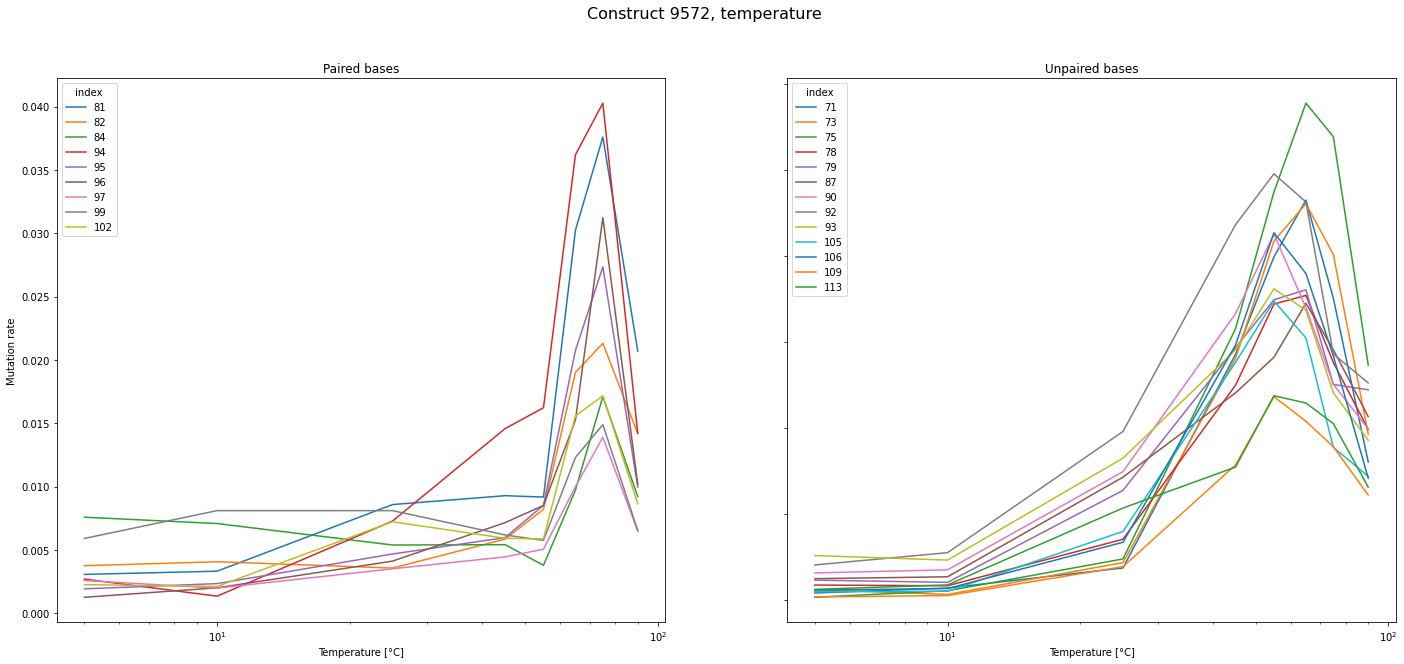

In [8]:
plot.study_base_wise_mut_rate(df=df,
                        study=Study().from_dict(studies.loc['temperature']),
                        construct=9572, 
                        scale_x='log', # can be log or lin
                        bases=['A','C'],  # bsaes you want in A, C, G, T
                        structure='full', # sequence for structure prediction. full or roi. 
                        #overlay = 10,  # expand/shrink the roi. Can't expand roi if structure = 'roi'
                        base_index=list(range(40,120))) # select your favorite bases. Can't expand roi if structure = 'roi' 